# EDA for Used Car Data

<div class="alert alert-block alert-info">
    
### Source Dataset :  

9996 used car listings scraped from a car website and augmented with additional data.
Please refer to the file UsedCarDataPreparation for details on the data synthesis

### EDA Objectives: 

1. Describe basic statistical data of the dataset
2. Explore data quality - Variances, Outliers, Distributions, Skewness
3. Perform label encoding and explore relationships
4. Execute initial basic model and explore results.

</div>



In [116]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format',lambda x: '%.2f' %x)
pd.set_option('display.max_rows',300)
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from sklearn.impute import KNNImputer
from scipy.stats import iqr
import missingno as msno

In [117]:
# Helper function
def findcolumntypes(dataframe):
    assert isinstance(dataframe,pd.DataFrame)
    allcolumns = dataframe.columns.to_list()
    numericals = dataframe._get_numeric_data().columns.to_list()
    categoricals = list(set(allcolumns) - set(numericals))
    collist =  dict(numeric = numericals,  categorical = categoricals)
    return collist

def smc(col):
    return df[df[col].isnull()][['make','model']].drop_duplicates()

## <span style="color:Blue"> Step 1: Read dataset, describe basic statistical data of the dataset, missing values </span>

In [118]:
# read the cars data from csv
df = pd.read_csv('cardata_final.csv',encoding = "ISO-8859-1",index_col=False)

In [119]:
# Number of examples
len(df)

9337

In [120]:
df.head(5)

,vin,year,make,model,trim,pricecategory,price,mileage,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,BrandReliabilityScore,CostOfLivingIndex,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid
0,WBY1Z2C51FV286674,2015,BMW,I3,60 AH,FAIR PRICE,15991,21493,BELLEVUE,WA,SILVER,GRAY,1,2,PERSONAL,N,HATCHBACK,123.00,112.20,1.78,74.00,7.50,113.00,Y
1,2GNAXHEV4J6220616,2018,CHEVROLET,EQUINOX,LS WITH 1LS FWD,FAIR PRICE,14899,37071,NORCO,CA,BLACK,GRAY,0,1,PERSONAL,Y,SUV,123.00,142.70,11.69,78.23,8.40,29.00,N
2,4S3GTAD6XK3741106,2019,SUBARU,IMPREZA,2.0I PREMIUM 5-DOOR CVT,FAIR PRICE,19220,15914,STAFFORD,TX,RED,BEIGE,0,1,PERSONAL,N,SEDAN,154.00,91.70,4.13,23.23,7.70,33.00,N
3,2C4RDGCG8KR551301,2019,DODGE,GRAND CARAVAN,SXT,EXCELLENT PRICE,12993,42070,OCALA,FL,GRAY,BLACK,0,1,PERSONAL,Y,VAN/MINIVAN,158.00,99.20,2.13,98.54,6.80,21.00,N
4,5YFEPRAEXLP047434,2020,TOYOTA,COROLLA,LE CVT,EXCELLENT PRICE,13800,18725,BOERNE,TX,WHITE,BLACK,0,1,PERSONAL,N,SEDAN,113.00,91.70,12.19,43.23,7.90,32.00,N


In [121]:
collist = findcolumntypes(df)
print('Numeric columns({})      ==> {}'.format(len(collist['numeric']),collist['numeric']))
print('\n')
print('Categorical columns({})     ==> {}'.format(len(collist['categorical']),collist['categorical']))

Numeric columns(11)      ==> ['year', 'price', 'mileage', 'accidenthist', 'owner', 'BrandReliabilityScore', 'CostOfLivingIndex', 'PercentSales', 'AvgDaysToTurn', 'ReviewScore', 'AvgMPG']


Categorical columns(13)     ==> ['vin', 'make', 'state', 'usage', 'LuxurySportsOrHybrid', 'model', 'trim', 'city', 'colorinterior', 'bodytype', 'colorexterior', 'discount', 'pricecategory']


In [122]:
df.describe()

,year,price,mileage,accidenthist,owner,BrandReliabilityScore,CostOfLivingIndex,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG
count,9337.00,9337.00,9337.00,9337.00,9337.00,9264.00,9337.00,9269.00,9250.00,8669.00,8663.00
mean,2016.36,16700.90,54320.49,0.19,1.43,134.79,104.94,6.78,70.65,7.85,28.07
std,3.97,8976.11,46205.58,0.48,0.91,18.42,19.54,4.35,15.84,0.59,6.71
min,1997.00,1500.00,6.00,0.00,0.00,100.00,84.70,0.00,23.23,5.30,15.00
25%,2015.00,10597.00,25882.00,0.00,1.00,123.00,91.70,2.22,57.92,7.40,23.50
50%,2018.00,15690.00,35912.00,0.00,1.00,132.00,99.20,6.29,74.23,7.90,28.50
75%,2019.00,19995.00,72832.00,0.00,2.00,139.00,108.80,11.69,78.23,8.30,32.50
max,2020.00,74227.00,395720.00,5.00,10.00,220.00,197.60,13.83,123.69,9.30,131.00


Text(0.5, 1.0, 'Histogram of Price values')

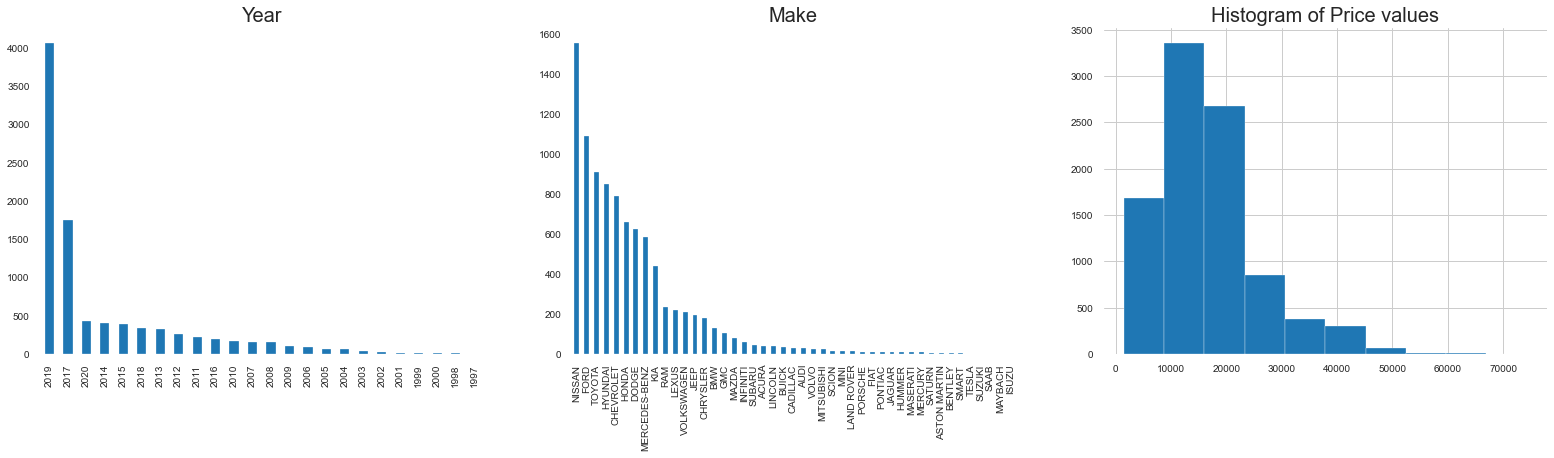

In [123]:
# Check data distributions by State Year and Make
fig,  (ax1, ax2,ax3) = plt.subplots(1, 3,figsize = (27,6))
df['year'].value_counts().plot(kind = 'bar',ax = ax1)
ax1.set_title("Year", fontsize=20)
df['make'].value_counts().plot(kind = 'bar',ax = ax2)
ax2.set_title("Make", fontsize=20)
df['price'].hist(bins=10,ax = ax3)
ax3.set_title("Histogram of Price values", fontsize=20)

<div class="alert alert-block alert-success">
    
### Results and Observations for Step 1 - Basic Stats on data :

1. 31 columns are present in the data set. 15 numerical and 16 categorical attributes.
    
2. As this data set is generated as part of data acquisition phase of this project , **_most of the data is already standardized during the data synthesis process_**.   
    
3. "vin" may not be an important feature for price determination, but it can help as an unique identifier.
    
4. Nulls observed in "cartype","ReliabilityRank","BrandPercentSales", "BrandAvgDaysToTurn","ReviewScore". This is due to unavailability of data for those makes - most of them are European makes or super luxury brands.
    
5. Proposed target variables - "price" and "pricecategory" are all non-null, no imputations required for them. 
    
6. 25% of the cars in the listing are older than 2015.   2019 cars are most frequent in the listing.
    
7. 75% of the listings have prices within 20k. Typical of used car values for cars older than 2 years.
    
8. There are cars listed with as many as 10 owners.

9. Nissan, Ford, Toyota, Hyndai, Chevrolet and Honda are the most frequently occuring Makes in the listing.
    
10. Price values are centered around 100k to 250k
    
</div>


## <span style="color:Blue"> Step 2: Explore data quality - Variances, Missing Values, Outliers, Distributions, Skewness </span>

### Missing data analysis


In [124]:
df.isnull().sum() * 100 / len(df)

vin                     0.00
year                    0.00
make                    0.00
model                   0.00
trim                    0.00
pricecategory           0.00
price                   0.00
mileage                 0.00
city                    0.00
state                   0.00
colorexterior           0.00
colorinterior           0.00
accidenthist            0.00
owner                   0.00
usage                   0.00
discount                0.00
bodytype                0.00
BrandReliabilityScore   0.78
CostOfLivingIndex       0.00
PercentSales            0.73
AvgDaysToTurn           0.93
ReviewScore             7.15
AvgMPG                  7.22
LuxurySportsOrHybrid    7.15
dtype: float64

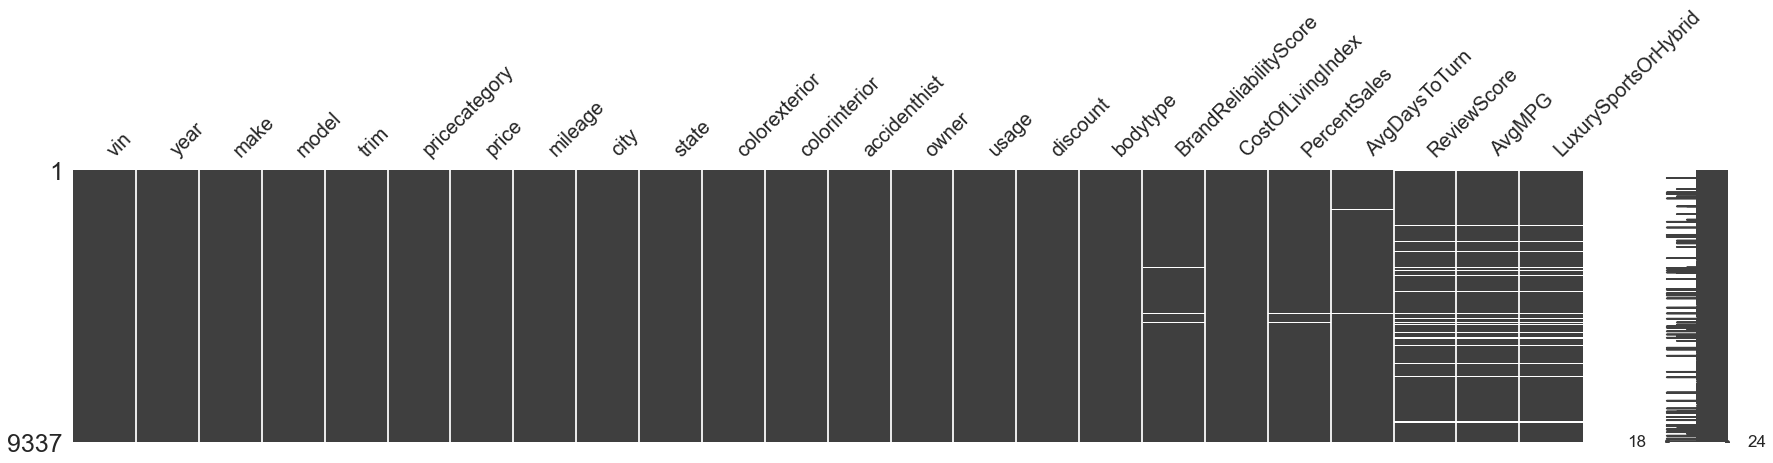

In [125]:
msno.matrix(df,figsize=(30,5), fontsize=20)

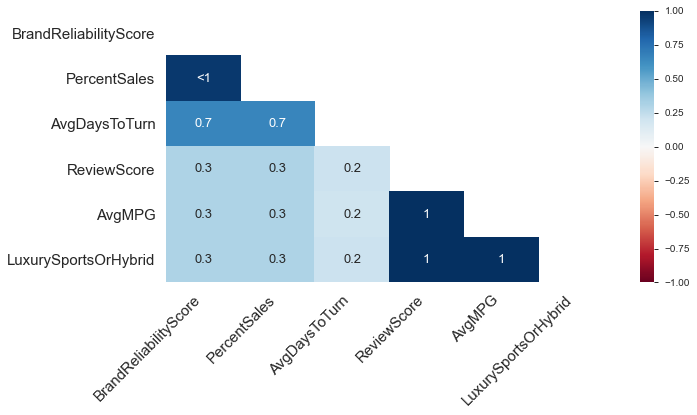

In [126]:
msno.heatmap(df,figsize=(10,5), fontsize=15)

<div class="alert alert-block alert-danger">
    
<br>   
   
#### **OBSERVATION : Missing Values**

    
- The NULL vlues in the columns are not clustered around any specific point, it is evenly distributed.
    
- Columns with Null value show correlations - this is because they are extracted from same or similar datasets from same population sample (reviews for a particular year range or specific makes)
   
<br>    
- (BrandReliabilityScore,PercentSales,AvgDaysToTurn)  are highly correlated for NULL values.
<br>
- (ReviewScore, AvgMPG,LuxurySportsOrHybrid)  are perfectly correlated for NULL values as they come from same data set.

<br>
    
_These data is mostly either from Super Luxury brands or from models older than 2012 which has not been considered for additional data._
 
#### **ACTION : Imputation of missing values  


| Columns with Missing Values |  Impute Strategy 
| --- |  --- 
| AvgMPG |  Mean from existing records with non-null data for AvgMPG based on bodytype
| BrandReliabilityScore |  Mean of existing values 
| PercentSales |  Mean of existing values
| AvgDaysToTurn |  Mean of existing values
| ReviewScore |  Mean of existing values
| LuxurySportsOrHybrid  |  'U'

    
- Add a new columns to indicate absence of data for the above fields as described below:

    
| New Indicator Column | Value determination
| --- |  --- 
| ReviewDataAvailable | 'N' if **any one** of the following columns is NULL, else 'Y'
    
    

   
</div>

### Missing data handling - imputations, creation of additional attributes to imply missing data

#### Create null indicator column and perform fillna's for imputing missing values

In [127]:
# Add the new column to indicate availability of data 
# if there is a null in any column, fill as N
df.loc[df.isnull().any(axis=1),'ReviewDataAvailable'] = 'N'
# for all other columns where all data is available, fill Y
df['ReviewDataAvailable'] = df['ReviewDataAvailable'].fillna('Y')

In [128]:
# Imputation for column: 'LuxurySportsOrHybrid'
df['LuxurySportsOrHybrid'] = df['LuxurySportsOrHybrid'].fillna('U')


# Imputation for columns: 'AvgMPG','BrandReliabilityScore','PercentSales','AvgDaysToTurn','ReviewScore'

# wherever possible, first try to impute with mean of the group
df['AvgMPG'] = df.groupby('bodytype')['AvgMPG'].transform(lambda grp: grp.fillna(np.mean(grp)))
df['BrandReliabilityScore'] = df.groupby('bodytype')['BrandReliabilityScore'].transform(lambda grp: grp.fillna(np.mean(grp)))
df['PercentSales'] = df.groupby('bodytype')['PercentSales'].transform(lambda grp: grp.fillna(np.mean(grp)))
df['AvgDaysToTurn'] = df.groupby('bodytype')['AvgDaysToTurn'].transform(lambda grp: grp.fillna(np.mean(grp)))
df['ReviewScore'] = df.groupby('bodytype')['ReviewScore'].transform(lambda grp: grp.fillna(np.mean(grp)))

# otherwise, if group level mean was not available impute with mean of the entire column
df['AvgMPG'] = df[['AvgMPG']].fillna(df['AvgMPG'].mean())
df['BrandReliabilityScore'] = df[['BrandReliabilityScore']].fillna(df['BrandReliabilityScore'].mean())
df['PercentSales'] = df[['PercentSales']].fillna(df['PercentSales'].mean())
df['AvgDaysToTurn'] = df[['AvgDaysToTurn']].fillna(df['AvgDaysToTurn'].mean())
df['ReviewScore'] = df[['ReviewScore']].fillna(df['ReviewScore'].mean())

#### Verify if there are any more missing values after imputation step

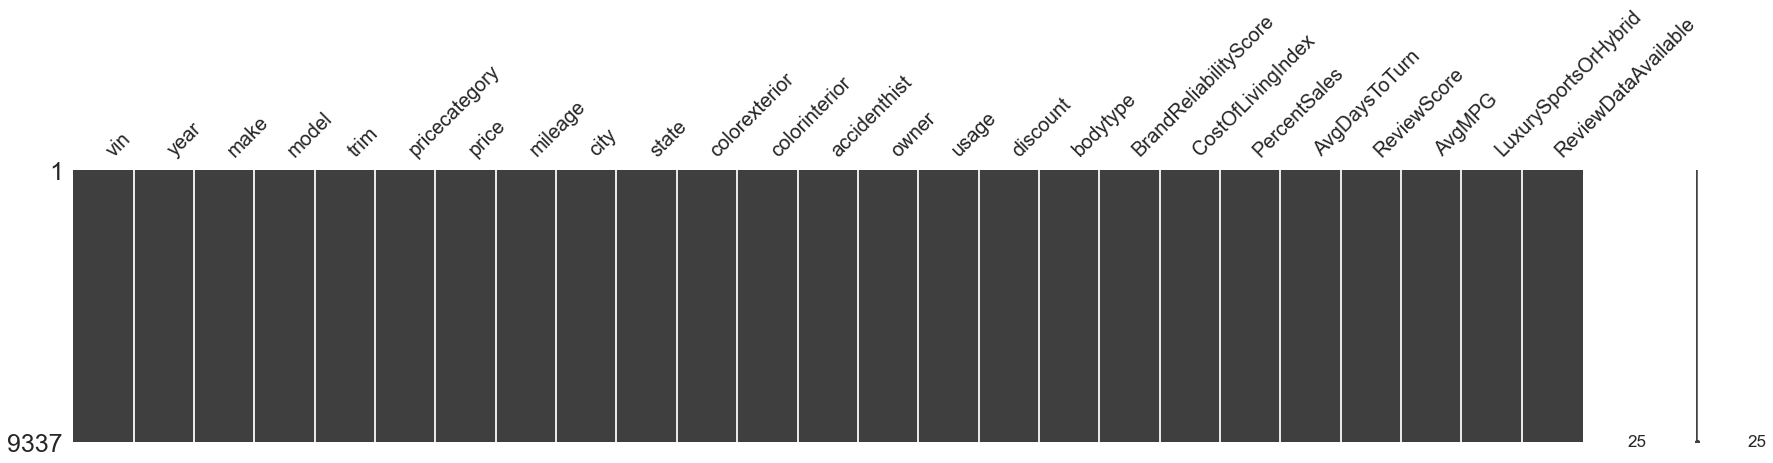

In [129]:
# Check null value distribution after impute

msno.matrix(df,figsize=(30,5), fontsize=20)

In [130]:
# Check null value counts after impute

df.isnull().sum().sum()

0

In [131]:
# Check the distribution of the new attribute ReviewDataAvailable
df['ReviewDataAvailable'].value_counts()

Y    8631
N     706
Name: ReviewDataAvailable, dtype: int64

### Skew and Outlier analysis


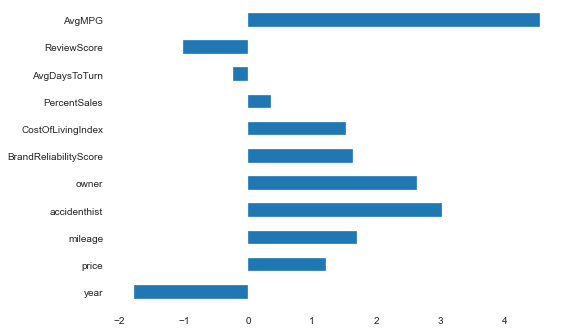

In [132]:
# check Skewness of columns
df.skew().plot(kind = 'barh')

In [133]:
# We see high skew values in the columns ('year','mileage','AvgMPG','owner','accidenthist')
# Exploring them further

df[['year','mileage','AvgMPG','owner','accidenthist']].describe()

,year,mileage,AvgMPG,owner,accidenthist
count,9337.00,9337.00,9337.00,9337.00,9337.00
mean,2016.36,54320.49,27.90,1.43,0.19
std,3.97,46205.58,6.70,0.91,0.48
min,1997.00,6.00,15.00,0.00,0.00
25%,2015.00,25882.00,23.00,1.00,0.00
50%,2018.00,35912.00,28.50,1.00,0.00
75%,2019.00,72832.00,32.00,2.00,0.00
max,2020.00,395720.00,131.00,10.00,5.00


<div class="alert alert-block alert-danger">

#### **OBSERVATION : Skewness**

_**AvgMPG** shows highest skewness towards right **accidenthist**_  

_**year** has highest skewness towards left followed by **ReviewScore** and **owner**_ 

    
<br>
    
- Most of the columns have the common/usual values seen in used car data. So these do not really have outliers. For example:
    
For **accidenthist**,  0 is the most common value. <br>
For **owner**, 1 and 2 are the most common values. <br>
For **reviewscore**, values 6.5 to 8 are common and also contains imputed mean values. 

- **year**, **mileage** and **AvgMPG** show a wide range of values and are good candidates for outlier analysis as done below.

    
</div>

Text(0.5, 1.0, 'accidenthist values in the outlier zone')

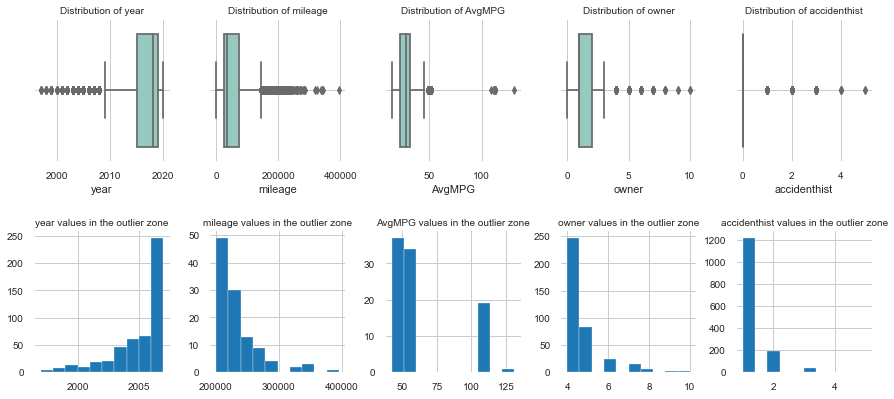

In [134]:
f, axes = plt.subplots(figsize=(15, 5),nrows = 2, ncols=5,sharex = False,sharey=False)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.3)

sns.boxplot( y=df["year"],palette="Set3",orient = 'h',ax = axes[0,0] )
axes[0,0].grid(True)
axes[0,0].set_title("Distribution of year",fontdict={'fontsize': 10, 'fontweight': 'medium'})

sns.boxplot(y = df["mileage"],palette="Set3", orient = 'h',ax = axes[0,1] )
axes[0,1].grid(True)
axes[0,1].set_title("Distribution of mileage",fontdict={'fontsize': 10, 'fontweight': 'medium'})


sns.boxplot( y=df["AvgMPG"],palette="Set3",orient = 'h',ax = axes[0,2] )
axes[0,2].grid(True)
axes[0,2].set_title("Distribution of AvgMPG",fontdict={'fontsize': 10, 'fontweight': 'medium'})

sns.boxplot( y=df["owner"],palette="Set3",orient = 'h',ax = axes[0,3] )
axes[0,3].grid(True)
axes[0,3].set_title("Distribution of owner",fontdict={'fontsize': 10, 'fontweight': 'medium'})


sns.boxplot( y=df["accidenthist"],palette="Set3",orient = 'h',ax = axes[0,4] )
axes[0,4].grid(True)
axes[0,4].set_title("Distribution of accidenthist",fontdict={'fontsize': 10, 'fontweight': 'medium'})


df[df['year'] < 2008]['year'].hist(ax = axes[1,0] )
axes[1,0].set_title("year values in the outlier zone",fontdict={'fontsize': 10, 'fontweight': 'medium'})
df[df['mileage'] > 200000]['mileage'].hist(ax = axes[1,1])
axes[1,1].set_title("mileage values in the outlier zone",fontdict={'fontsize': 10, 'fontweight': 'medium'})
df[df['AvgMPG'] > 40]['AvgMPG'].hist(ax = axes[1,2])
axes[1,2].set_title("AvgMPG values in the outlier zone",fontdict={'fontsize': 10, 'fontweight': 'medium'})
df[df['owner'] > 3]['owner'].hist(ax = axes[1,3])
axes[1,3].set_title("owner values in the outlier zone",fontdict={'fontsize': 10, 'fontweight': 'medium'})
df[df['accidenthist'] > 0]['accidenthist'].hist(ax = axes[1,4])
axes[1,4].set_title("accidenthist values in the outlier zone",fontdict={'fontsize': 10, 'fontweight': 'medium'})


<div class="alert alert-block alert-danger">
   
#### **OBSERVATION : Outliers**

- **Outliers seen for year < 2004** : It is common for used cars listings to have cars older than 10-15 years. 
    
- **Outliers seen for mileage > 150000** : It is common for used cars to have mileage > 150000, but here mileage values > 250000 are observed

- **Outliers seen for AvgMPG > 45** :  Electric/Hybrid/small may have AvgMPG > 45
    
- **Outliers seen for owner > 0** :  It is common for used cars listings to have more than 1 owners
    
- **Outliers seen for accidenthist > 0** :  It is uncommon for used car listings to have more than 2 accidents, No accident is most common
    
    
#### **ACTION : Creation of Dervied features**
    
New features can be derived from these features to incorporate outlier values instead of dropping them. These features are as follows:
    
    
| New Column | Root Column | Value derivation
| --- |  --- |  ---
| age | year | number of years older based on current year 2020 (= '2020 - year')
| prevowners | owner |  cap max value to 2.
| mileage | owner |  cap max value to 250000
    
    
    
</div>

In [140]:
# Create the new columns as mentioned above
# Moving to catrgorical features

# convert year to age
df['age'] = 2020 - df['year'] 

# Cap prevowners value to 250000
df['ownerhist'] = df['owner'].apply(lambda x:2 if x >= 2 else x)

# Cap Mileage value to 250000
df['odometer'] = df['mileage'].apply(lambda x:250000 if x >= 250000 else x)

df.drop(columns = ['year','owner','mileage'], inplace = True) 

In [141]:
df.sample(5)

,vin,make,model,trim,pricecategory,price,city,state,colorexterior,colorinterior,accidenthist,usage,discount,bodytype,BrandReliabilityScore,CostOfLivingIndex,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid,ReviewDataAvailable,age,ownerhist,odometer
33,KNMAT2MT2JP500438,NISSAN,ROGUE,S FWD,FAIR PRICE,12499,STANTON,CA,BLACK,BLACK,1,PERSONAL,N,SUV,136.00,142.70,6.29,76.23,7.40,29.50,N,Y,2,1,72603
6628,5NMS23AD7KH082253,HYUNDAI,SANTA FE,SE 2.4L FWD,GREAT PRICE,18500,HOUSTON,TX,GRAY,UNKNOWN,0,PERSONAL,N,SUV,132.00,91.70,4.16,79.08,8.50,25.50,N,Y,1,1,29832
815,3N1AB7AP4KY421783,NISSAN,SENTRA,SV CVT,EXCELLENT PRICE,14490,SACRAMENTO,CA,GRAY,BLACK,0,PERSONAL,Y,SEDAN,136.00,142.70,6.29,76.23,7.20,33.00,N,Y,1,0,1680
1276,WBA3A9C54EF478137,BMW,3 SERIES,335I SEDAN,NOT LISTED,12577,NAPERVILLE,IL,BLACK,BLACK,1,PERSONAL,N,SEDAN,123.00,89.70,1.78,74.00,7.70,31.00,Y,Y,6,2,91564
4288,5UXWX9C54E0D27804,BMW,X3,XDRIVE28I AWD,EXCELLENT PRICE,11888,SAN ANTONIO,TX,BLUE,BEIGE,1,PERSONAL,N,SUV,123.00,91.70,1.78,74.00,8.60,26.50,Y,Y,6,1,106372


In [142]:
# Check null values if any after these new columns are added
df.isnull().sum()

vin                      0
make                     0
model                    0
trim                     0
pricecategory            0
price                    0
city                     0
state                    0
colorexterior            0
colorinterior            0
accidenthist             0
usage                    0
discount                 0
bodytype                 0
BrandReliabilityScore    0
CostOfLivingIndex        0
PercentSales             0
AvgDaysToTurn            0
ReviewScore              0
AvgMPG                   0
LuxurySportsOrHybrid     0
ReviewDataAvailable      0
age                      0
ownerhist                0
odometer                 0
dtype: int64

In [97]:
df.dtypes

vin                        object
make                       object
model                      object
trim                       object
pricecategory              object
price                       int64
mileage                     int64
city                       object
state                      object
colorexterior              object
colorinterior              object
usage                      object
discount                   object
bodytype                   object
BrandReliabilityScore     float64
CostOfLivingIndex         float64
PercentSales              float64
AvgDaysToTurn             float64
ReviewScore               float64
AvgMPG                    float64
LuxurySportsOrHybrid       object
ReviewDataAvailable        object
age                         int64
prevowners               category
accidents                  object
dtype: object

<div class="alert alert-block alert-success">
    
### Results and Observations for Step 2 - Handling missing data and outliers:

1. All missing data were imputed based on the logic described above.
    
2. Outliers have been detected. 
    
3. Derived columns have been created from  the columns having outliers and original columns have been removed.
    
</div>


## <span style="color:Blue"> Step 3: Perform label encoding and explore relationships </span>

In [143]:
# drop columns which may not contribute effectively
# vin is just an identifier 
# trim has got too many variations in values and cannot be encoded
# city level categorization is not required - can be done at state level
df2 = df.drop(columns = ['vin','trim','city'])

In [144]:
for col in df2.select_dtypes(include=['category']).columns:
    df2[col] = df2[col].cat.codes
for col in df2.select_dtypes(include=['object']).columns:
    df2[col] = df2[col].astype('category')
    df2[col] = df2[col].cat.codes

In [145]:
#df3 = pd.get_dummies(df2, drop_first=True)

In [146]:
df2.sample(10)

,make,model,pricecategory,price,state,colorexterior,colorinterior,accidenthist,usage,discount,bodytype,BrandReliabilityScore,CostOfLivingIndex,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid,ReviewDataAvailable,age,ownerhist,odometer
4947,20,135,0,11210,33,15,1,0,1,1,4,132.00,155.90,3.99,73.38,8.40,36.00,0,1,3,1,14486
2751,31,287,0,16299,41,1,1,0,1,1,6,136.00,90.00,6.29,76.23,7.40,29.50,0,1,1,1,34554
7614,12,395,0,40995,3,15,1,0,1,1,6,162.00,100.10,3.39,72.08,6.50,18.50,0,1,1,1,22159
4148,0,281,0,17450,4,11,1,0,1,1,6,139.00,142.70,0.88,65.54,7.90,25.00,2,1,7,2,46920
7767,42,48,2,17988,3,11,4,0,1,1,4,113.00,100.10,12.19,43.23,8.70,35.00,0,1,1,1,31553
1857,27,148,0,24991,42,1,1,1,0,0,6,152.00,91.70,2.21,57.92,8.40,19.00,2,1,2,1,11439
5737,15,106,2,14920,42,5,4,0,1,0,4,132.00,91.70,4.16,79.08,8.10,31.00,0,1,1,1,21537
3693,7,53,3,3299,42,10,8,0,1,0,4,123.00,91.70,11.69,78.23,7.40,25.00,2,1,16,2,89393
6226,13,62,0,5992,8,10,0,1,1,1,4,139.00,99.20,8.34,48.69,8.20,34.00,0,1,7,2,148540
5120,13,86,0,7995,42,3,0,0,1,0,6,139.00,91.70,8.34,48.69,8.50,29.00,0,1,9,2,135632


In [147]:
# verify no records are lost
len(df2)

9337

In [148]:
# Verify all data types are numeric
df2.dtypes

make                        int8
model                      int16
pricecategory               int8
price                      int64
state                       int8
colorexterior               int8
colorinterior               int8
accidenthist               int64
usage                       int8
discount                    int8
bodytype                    int8
BrandReliabilityScore    float64
CostOfLivingIndex        float64
PercentSales             float64
AvgDaysToTurn            float64
ReviewScore              float64
AvgMPG                   float64
LuxurySportsOrHybrid        int8
ReviewDataAvailable         int8
age                        int64
ownerhist                  int64
odometer                   int64
dtype: object

In [149]:
# Verify that there are no null values
df2.isnull().sum().sum()

0

<div class="alert alert-block alert-success">

### At this point,  ALL NUMERIC *** NO NULLS
    
- all categorical columns have been label encoded to numeric
- no non-numeric columns are present in the data set
- no null values are present in the data set
    
</div>

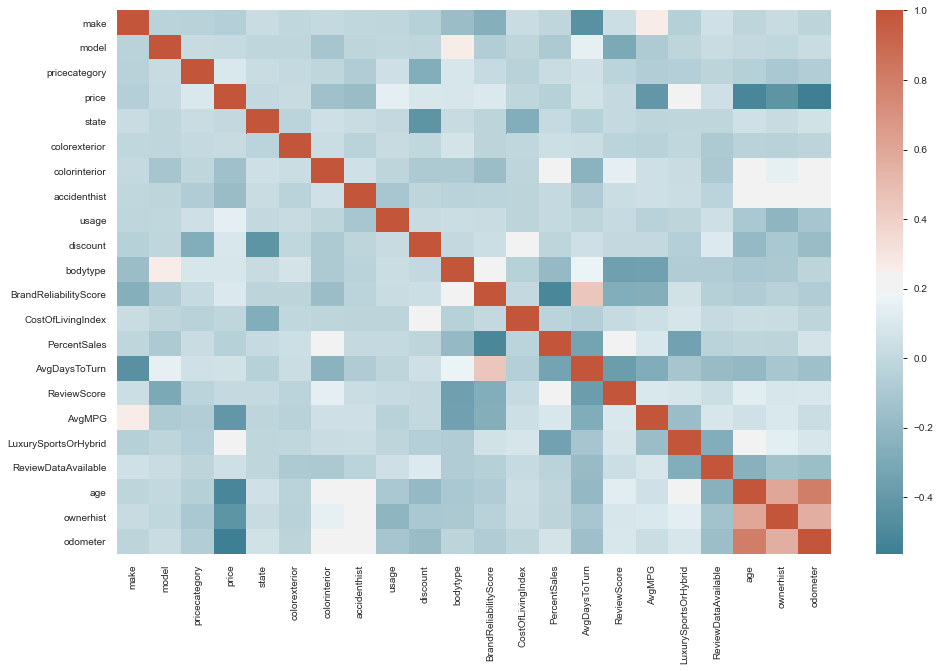

In [150]:
# plot the correlation heatmap for all columns
corr = df2.corr()
plt.figure(figsize = (16,10))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, cmap=sns.diverging_palette(220, 20, as_cmap=True))

<div class="alert alert-block alert-success">
    
#### Observations on the correlation heatmap

- Correlations with target variables **price** and **pricecategory**:
    

    1. Price - high positive correlation with age, ownerhist, odometer,accidenthist.  Weak correlations with colorinterior,make, percentsales
    2. pricecategory - average correlation with discount and mileage
    
- Other strongly correlated values: 
    
    age/ownerhist/odometer <br>
    reliabilityscore/pecentsales <br>
    make/avgdaystoturn <br>
    bodytype/mpg <br>
    discount/state <br>
    
    
    
</div>    

In [58]:
#profile = ProfileReport(df2)
#profile.to_file('carprofile.html')

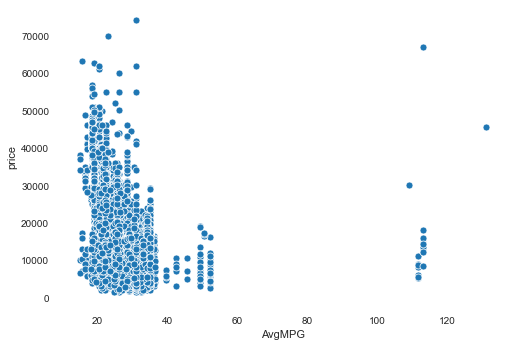

In [151]:
ax = sns.scatterplot(x = 'AvgMPG', y = 'price', data=df)  

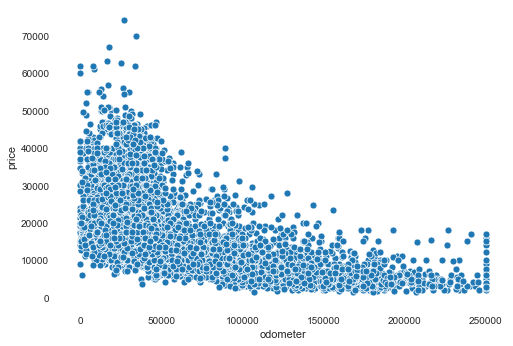

In [153]:
ax = sns.scatterplot(x = 'odometer', y = 'price', data=df)


## <span style="color:Blue"> Step 4: Execute initial basic model and explore results </span>

In [154]:
df2

,make,model,pricecategory,price,state,colorexterior,colorinterior,accidenthist,usage,discount,bodytype,BrandReliabilityScore,CostOfLivingIndex,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid,ReviewDataAvailable,age,ownerhist,odometer
0,4,176,1,15991,46,11,4,1,1,0,2,123.00,112.20,1.78,74.00,7.50,113.00,2,1,5,2,21493
1,7,113,1,14899,4,1,4,0,1,1,6,123.00,142.70,11.69,78.23,8.40,29.00,0,1,2,1,37071
2,39,184,1,19220,42,10,0,0,1,0,4,154.00,91.70,4.13,23.23,7.70,33.00,0,1,1,1,15914
3,9,158,0,12993,8,5,1,0,1,1,9,158.00,99.20,2.13,98.54,6.80,21.00,0,1,1,1,42070
4,42,78,0,13800,42,15,1,0,1,0,4,113.00,91.70,12.19,43.23,7.90,32.00,0,1,0,1,18725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9332,31,306,0,13995,42,1,1,0,1,0,4,136.00,91.70,6.29,76.23,7.20,33.00,0,1,1,1,2816
9333,42,279,0,18495,26,11,8,0,1,1,6,113.00,95.50,12.19,43.23,7.90,30.50,0,1,2,1,43908
9334,31,349,0,13000,42,11,1,0,0,0,4,136.00,91.70,6.29,76.23,7.70,18.00,0,1,5,1,139839
9335,11,127,0,19900,42,15,4,0,1,0,3,126.00,91.70,13.83,71.62,8.80,22.00,0,1,5,1,93501


In [157]:
# Scale Price values and Odometer values for model stability

from sklearn.preprocessing import StandardScaler

scalecols = ['price', 'odometer']
features = df2[scalecols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df2[scalecols] = features

In [158]:
df2

,make,model,pricecategory,price,state,colorexterior,colorinterior,accidenthist,usage,discount,bodytype,BrandReliabilityScore,CostOfLivingIndex,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid,ReviewDataAvailable,age,ownerhist,odometer
0,4,176,1,-0.08,46,11,4,1,1,0,2,123.00,112.20,1.78,74.00,7.50,113.00,2,1,5,2,-0.72
1,7,113,1,-0.20,4,1,4,0,1,1,6,123.00,142.70,11.69,78.23,8.40,29.00,0,1,2,1,-0.38
2,39,184,1,0.28,42,10,0,0,1,0,4,154.00,91.70,4.13,23.23,7.70,33.00,0,1,1,1,-0.84
3,9,158,0,-0.41,8,5,1,0,1,1,9,158.00,99.20,2.13,98.54,6.80,21.00,0,1,1,1,-0.27
4,42,78,0,-0.32,42,15,1,0,1,0,4,113.00,91.70,12.19,43.23,7.90,32.00,0,1,0,1,-0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9332,31,306,0,-0.30,42,1,1,0,1,0,4,136.00,91.70,6.29,76.23,7.20,33.00,0,1,1,1,-1.12
9333,42,279,0,0.20,26,11,8,0,1,1,6,113.00,95.50,12.19,43.23,7.90,30.50,0,1,2,1,-0.23
9334,31,349,0,-0.41,42,11,1,0,0,0,4,136.00,91.70,6.29,76.23,7.70,18.00,0,1,5,1,1.87
9335,11,127,0,0.36,42,15,4,0,1,0,3,126.00,91.70,13.83,71.62,8.80,22.00,0,1,5,1,0.86


In [189]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae


# Get dependent and independent variables in arrays

# X is all columns except price
X = df2.loc[:,~df2.columns.isin(['price','pricecategory']) ]

y1 = df2['price']
y2 = df2['pricecategory']



### Showing model predictions for target = price

In [190]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=.25, random_state=0)

# Create a Random Forest Regressor with default parameters
model1 = RandomForestRegressor(random_state=1)
model1.fit(X_train, y_train)
pred = model1.predict(X_test)

In [191]:
mae(y_test, pred)

0.18106348467622133

In [192]:
model1.score(X_test,y_test)

0.8988872553161911

### Showing model predictions for target = pricecategory

In [193]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=.25, random_state=0)

# Create a Random Forest Regressor with default parameters
model2 = RandomForestRegressor(random_state=1)
model2.fit(X_train, y_train)
pred = model2.predict(X_test)

In [194]:
mae(y_test, pred)

0.5995802997858672

In [195]:
model2.score(X_test,y_test)

0.40866116321669566

# -------------------------------------------------------------------------------------------------------------

In [205]:
feat_price = pd.DataFrame(model1.feature_importances_,
                          index = df2.columns[~df2.columns.isin(['price','pricecategory'])],
                          columns = ['ImportanceScore']
                          )


In [206]:
feat_price

,ImportanceScore
make,0.02
model,0.04
state,0.01
colorexterior,0.00
colorinterior,0.00
accidenthist,0.00
usage,0.00
discount,0.00
bodytype,0.01
BrandReliabilityScore,0.01


In [208]:
feat_price.sort_values('ImportanceScore', ascending = False)

,ImportanceScore
AvgMPG,0.36
odometer,0.33
age,0.07
ReviewScore,0.05
model,0.04
LuxurySportsOrHybrid,0.04
PercentSales,0.02
AvgDaysToTurn,0.02
make,0.02
CostOfLivingIndex,0.01


<div class="alert alert-block alert-success">
    
# Results and Observations for Step 5 - Execute basic feature selection:

## price has 89% accuracy score with a RandomForestRegressor - may be overfit.
## pricecategory shows only a 40% accuracy  
    
10 most imporant features according to RandomForest are :
    
    
    AvgMPG	 
    odometer	 
    age	 
    ReviewScore 
    model	 
    LuxurySportsOrHybrid 
    PercentSales	 
    AvgDaysToTurn	 
    make 
    CostOfLivingIndex 
    
    
</div>
